### Title: RandomWalk, SARIMA and Seasonal ES

Author: Yiran Jing

Date: 15-10-2018



### Univariate - Modelling selection 
- Nnive Random Walk - One setp ahead **Baseline**
- Seasonal RW - One day before **Baseline**
- Seasonal RW - One week before **Baseline**
- Double Seasonal ARIMA - univariate (within-day and within-week seasonality)

### Model forecast

- Real time forecast by Rolling Window (one step ahead)
- Real time forecast by expanding Window (one step ahead)

##### Real time forecast
At each preiod t, we use **all availiable** data to estimate the model and then preodict the future

** One-step ahead forecast**

Start at time $t = n$, use all abservations from $t = 1 : t$ to estimate model, and then use the estimated model to forecast $y_{t+1}$, then repeat the above step for multiple times. Then, compulate the forecast accuracy measures



Two schemes for updating the estimation sample at each validation period
- **Expanding window ** At each step, add the latest observation to the estimation sample
- **Rolling window ** The most common approach: At each step, use only the most recent n observation for estimation. This method implicitly assumes that the dynamtics of the series has a time changing nature, so the data far in the past are less relevant for estimation

To be more informative and comfident, we use both of them and compare the results for each model!



### Residual diagnostics 
 - ACF and PACF plots (Residual vs Time)
 - Residual distribution (histogram and QQ plot)

### Performance Measures

How well the model perfoms on data not used in estimation, based on test dataset
##### 1. Point forecast (Best guess) measure
- MAPE 

Recall that the mean precentage error is given by $$p_t = 100*(|(y_t - \hat{y_t})|/y_t) $$

Compared to RMSE, it has advantage of being **scale-independent**, but its disadvantage of being infinite or undefined if $y_t = 0 $ for any interested period t, and has extreme value when any $y_t$ close to 0.

- MAE

##### 2. Interval Forecast measure
- Bootstrap CI



In [ ]:
from collections import Counter
import pandas as pd
import csv
import pprint
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
from collections import defaultdict
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib as mpl
from pandas import Series
from matplotlib import pyplot
from time_series import ts_plot,ts_plot2,ts_plot3,acf_pacf_plot,hist,modify_time_format,epoch_seconds_to_timestamp
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import glob, os
from matplotlib import pyplot as plt
from time_series import plot_regressions,plot_time_decomposition,time_series_SA,time_series_weather_SA,group_holiday_plot,bonxcox_transf
from time_series import difference,first_diff,first_seasonal_diff,seasonal_diff,data_time,data_origin_first_seasonal_firstSeasonal
from time_series import draw_acf_acf,draw_diff_plot,draw_diff_plot
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

In [24]:
power_stationary = pd.read_csv('../data/stationary_data.csv',)
power_origin = pd.read_csv('../data/demand_temp_price.csv',)
power_origin = power_origin[49:]


##### Train Test Split
If we want a test set of approximately 20% then we need the last two months of data which are March 2017 and April 2017. This gives us a test set of approximately 18.5%

train : 2016-05-02 - 2017-01-01

val set: 2017-01-01 - 2017-02-28

test set: 2017-02-28 - 2017-04-30


In [25]:
power_origin = power_origin.set_index(power_origin.period)
train_data_origin = power_origin[power_origin.index < "2017-03-01"]
test_data_origin = power_origin[power_origin.index >= "2017-03-01"]
val_data_origin = train_data_origin[train_data_origin>="2017-01-01"]
train_data_origin = power_origin[power_origin.index < "2017-01-01"]
power_origin.head(3)

,period,demand,air_temp,price
period,,,,
2016-05-02 01:00,2016-05-02 01:00,1343.35,18.2,57.58
2016-05-02 01:30,2016-05-02 01:30,1257.92,18.6,40.62
2016-05-02 02:00,2016-05-02 02:00,1176.45,19.0,42.37


In [26]:
power_stationary = power_stationary.set_index(power_stationary.period)
train_data_stationary = power_stationary[power_stationary.index < "2017-03-01"]
val_data_stationary = power_stationary[power_stationary.index >= "2017-01-01"]
test_data_stationary = power_stationary[power_stationary.index >= "2017-03-01"]
val_data_stationary = train_data_stationary[train_data_stationary>="2017-01-01"]
train_data_stationary = power_stationary[power_stationary.index < "2017-01-01"]
power_stationary.head(3)

,demand,price,air_temp,period
period,,,,
2016-05-02 01:00:00,14.23,-4.18,0.25,2016-05-02 01:00:00
2016-05-02 01:30:00,-16.37,-16.96,0.30,2016-05-02 01:30:00
2016-05-02 02:00:00,-14.88,1.75,0.30,2016-05-02 02:00:00


### Model 1: BenchMark - Naive Random Walk

**Note: RW use origion, non-stationary data only**
- one setp ahead 
- seasonal RW (one day before)
- seasonal RW (one week before)

In [27]:
def naive_RW_Seasonal(prod, freq, train_data, val_data):
    """
    Naive/ Random Walk Model. Use y_{t-freq} to predict y_t.
    
    Parameters
    ----------
    prod:
        Interested product 
    freq:
        The seasonal period, Integer
    train_data: dataframe
        The training set containing all products.
    val_data: dataframe
        The validation set containing all products.
        
    Returns
    --------
    results : dictionary
        Key is product and value is the MSE.
    """
    
    # Compute metric for each product.
    diff = []
    RWS_pred = []
    # Just for the 1-step ahead forecast.
    diff.append(abs(train_data[prod].iloc[len(train_data[prod])-freq] - val_data[prod].iloc[0])/abs(val_data[prod].iloc[0]))
    RWS_pred.append(val_data[prod].iloc[0])
    
    for i in range(1, len(val_data[prod])):
    # Loop through and use y_t-1 to predict y_t.
    # CHANGE THIS LINE TO CHANGE ERROR METRIC.
        diff.append(100*(abs(val_data[prod].iloc[i] - val_data[prod].iloc[i-freq])/abs(val_data[prod].iloc[i])))
        RWS_pred.append(val_data[prod].iloc[i-freq])
        
    # Add the result to dictionary.
    rws_MAPE = sum(diff)/len(diff)
    #rw_MAPE = mean_absolute_percentage_error(val_data[prod],RWS_pred)
    rws_MAE = mean_absolute_error(val_data[prod],RWS_pred) 
    return RWS_pred, rws_MAPE, rws_MAE

### Fixed window forecast

In [28]:
def Fixed_window_Forecast_RW(val_data, train_data, prod, freq1, freq2):
    import warnings
    warnings.filterwarnings('ignore')
    """
    Real time forecastig by Rolling Window
    
    Model
    ------
    Radom Walk
    Exponential smoothing
    AR(1)
    
    Parameters
    --------
    prod:
        Interested product
    freq1:
        The in day seasonal period in seasonal RW, Integer
    freq2:
        The in week seasonal period in seasonal RW, Integer    
    train, test: 
        The training and test datasets.
    
    Returns
    --------
    Forecast results: 
        MAPE of each model
        MAE of each model
    """
    # data prepare
    train_data[prod] = train_data[prod].astype('float64')
    val_data[prod] = val_data[prod].astype('float64')
    
    RW_pred = [];RWS_pred=[];RWSS_pred =[]
    actual = []
    
    ########################
    ##   Fit RW Banch mark #
    ########################
    # Fit Randow Walk model (one-step ahead)
    RW_pred, rw_MAPE, rw_MAE = naive_RW_Seasonal(prod, 1, train_data, val_data)
    # Fit Randow Walk model (one-day ahead)
    RWS_pred, rws_MAPE, rws_MAE = naive_RW_Seasonal(prod, 48, train_data, val_data)
    # Fit Randow Walk model (one-week ahead)
    RWSS_pred, rwss_MAPE, rwss_MAE = naive_RW_Seasonal(prod, 48*7, train_data, val_data)
    
    for i in range(0, len(val_data[prod])):
        actual.append(val_data[prod].iloc[i]) 
            
    # print table
    columns=['Rand Walk (One step ahead)',"Sens RW (In-day)","Sens RW (In-week)",'Actual']
    results = np.vstack([RW_pred, RWS_pred, RWSS_pred, actual]).T
    results = pd.DataFrame(results, columns=columns, index=val_data.index)
    MAPE = [rw_MAPE, rws_MAPE,rwss_MAPE]
    MAE = [rw_MAE, rws_MAE, rwss_MAE]
    table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['MAPE (%)','MAE'])
    for i in range(3): # the number of model
        table.iloc[i,0] = round(MAPE[i],4)
        table.iloc[i,1] = MAE[i]
    return table.round(3)
    

In [29]:
Fixed_window_Forecast_RW(val_data_origin, train_data_origin, 'demand', 48, 48*7)

,MAPE (%),MAE
Rand Walk (One step ahead),3.957,49.395
Sens RW (In-day),14.606,162.073
Sens RW (In-week),17.128,193.171


## RW for test data

In [30]:
Fixed_window_Forecast_RW(test_data_origin, val_data_origin, 'demand', 48, 48*7)

,MAPE (%),MAE
Rand Walk (One step ahead),3.004,39.635
Sens RW (In-day),12.116,161.103
Sens RW (In-week),14.635,194.068


### Rolling window forecast

In [19]:
def Rolling_Forecast(val_data, train_data, prod, freq1, freq2):
    """
    Real time forecastig by Rolling Window
    
    Model
    ------
    Radom Walk
    Exponential smoothing
    AR(1)
    
    Parameters
    --------
    prod:
        Interested product
    freq1:
        The in day seasonal period in seasonal RW, Integer
    freq2:
        The in week seasonal period in seasonal RW, Integer    
    train, test: 
        The training and test datasets.
    
    Returns
    --------
    Forecast results: 
        MAPE of each model
        MAE of each model
    """
    # data prepare
    train_data[prod] = train_data[prod].astype('float64')
    val_data[prod] = val_data[prod].astype('float64')
    
    RW_pred = [];RWS_pred=[];RWSS_pred =[]
    #SARIMA_pred = []
    SES_coll = []
    actual = []
    
    # the updated data, which are related to window method
    val_data_reduce = val_data.copy()
    train_data_vary = train_data.copy()
    
    
    # real time forecasting based on test data! 
    for i in range(0, len(val_data[prod])):

        # Actual value
        actual.append(val_data[prod].iloc[i]) 
        
        # Seasonl Exponentionnal Smoothing
        # learn model outside
        SES = ExponentialSmoothing(train_data_vary[prod], seasonal='mul', seasonal_periods=48).fit()
        SES_pred = SES.predict()  #one step ahead
        SES_coll.append(SES_pred) 
        diff2 =[] # MAPE
        diff2.append(100*(abs(SES_pred[-1] - val_data[prod].iloc[i])/val_data[prod].iloc[i])) 
        

        ## Rolling Window  
        ## At each setp, use the most rencent n observation as training data
        train_data_vary = train_data.copy().append(val_data.head(i+1)) # add the lastest observation
        train_data_vary = train_data_vary.drop(index = train_data.index[:i]) # drop one most far away observation
        val_data_reduce = val_data_reduce.drop(index = val_data.index[i]) # delate the observation, as it add to train set
        print('😊😊😊')
    
    
    
    RW_pred, rw_MAPE, rw_MAE = naive_RW_Seasonal(prod, 1, train_data, val_data)
    RWS_pred, rws_MAPE, rws_MAE = naive_RW_Seasonal(prod, 48, train_data, val_data)
    RWSS_pred, rwss_MAPE, rwss_MAE = naive_RW_Seasonal(prod, 48*7, train_data, val_data)
    ses_MAPE = sum(diff2)/len(diff2)
    ses_MAE = mean_absolute_error(val_data[prod],SES_coll)
    
    # print table
    columns=['Rand Walk (One step ahead)',"Sens RW (In-day)","Sens RW (In-week)",'Seasonal ES','Actual']
    results = np.vstack([RW_pred,RWS_pred, RWSS_pred, actual]).T
    results = pd.DataFrame(results, columns=columns, index=val_data.index)
    MAPE = [rw_MAPE, rws_MAPE,rws_MAE,ses_MAPE]
    MAE = [rw_MAE, rws_MAE, rwss_MAE, ses_MAE]
    table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['MAPE (%)','MAE'])
    for i in range(4): # the number of model
        table.iloc[i,0] = round(MAPE[i],4)
        table.iloc[i,1] = MAE[i]
    return table.round(3)
    

So our benchmark should be random walk one-step ahead

In [9]:
RW_pred, rw_MAPE, rw_MAE = naive_RW_Seasonal('demand', 1, \
                                             train_data_origin, val_data_origin)

### Model 2: Seasonal Exponentional Smoothing
Based on the autocorrelation residual plots below, residual is not stationary, not white noise！ it is bad!

In [50]:
SES = ExponentialSmoothing(train_data_origin['demand'], seasonal='multi', seasonal_periods=48).fit()
#SES = sm.tsa.statespace.SARIMAX(train_data_origin['demand'], trend='n', order=(4,1,0), seasonal_order=(0,1,1,48))

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [51]:
SES_fitted = SES.predict(start=0,end=(len(train_data_origin['demand'])-1))
ses_resid = train_data_origin['demand']-SES_fitted

/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


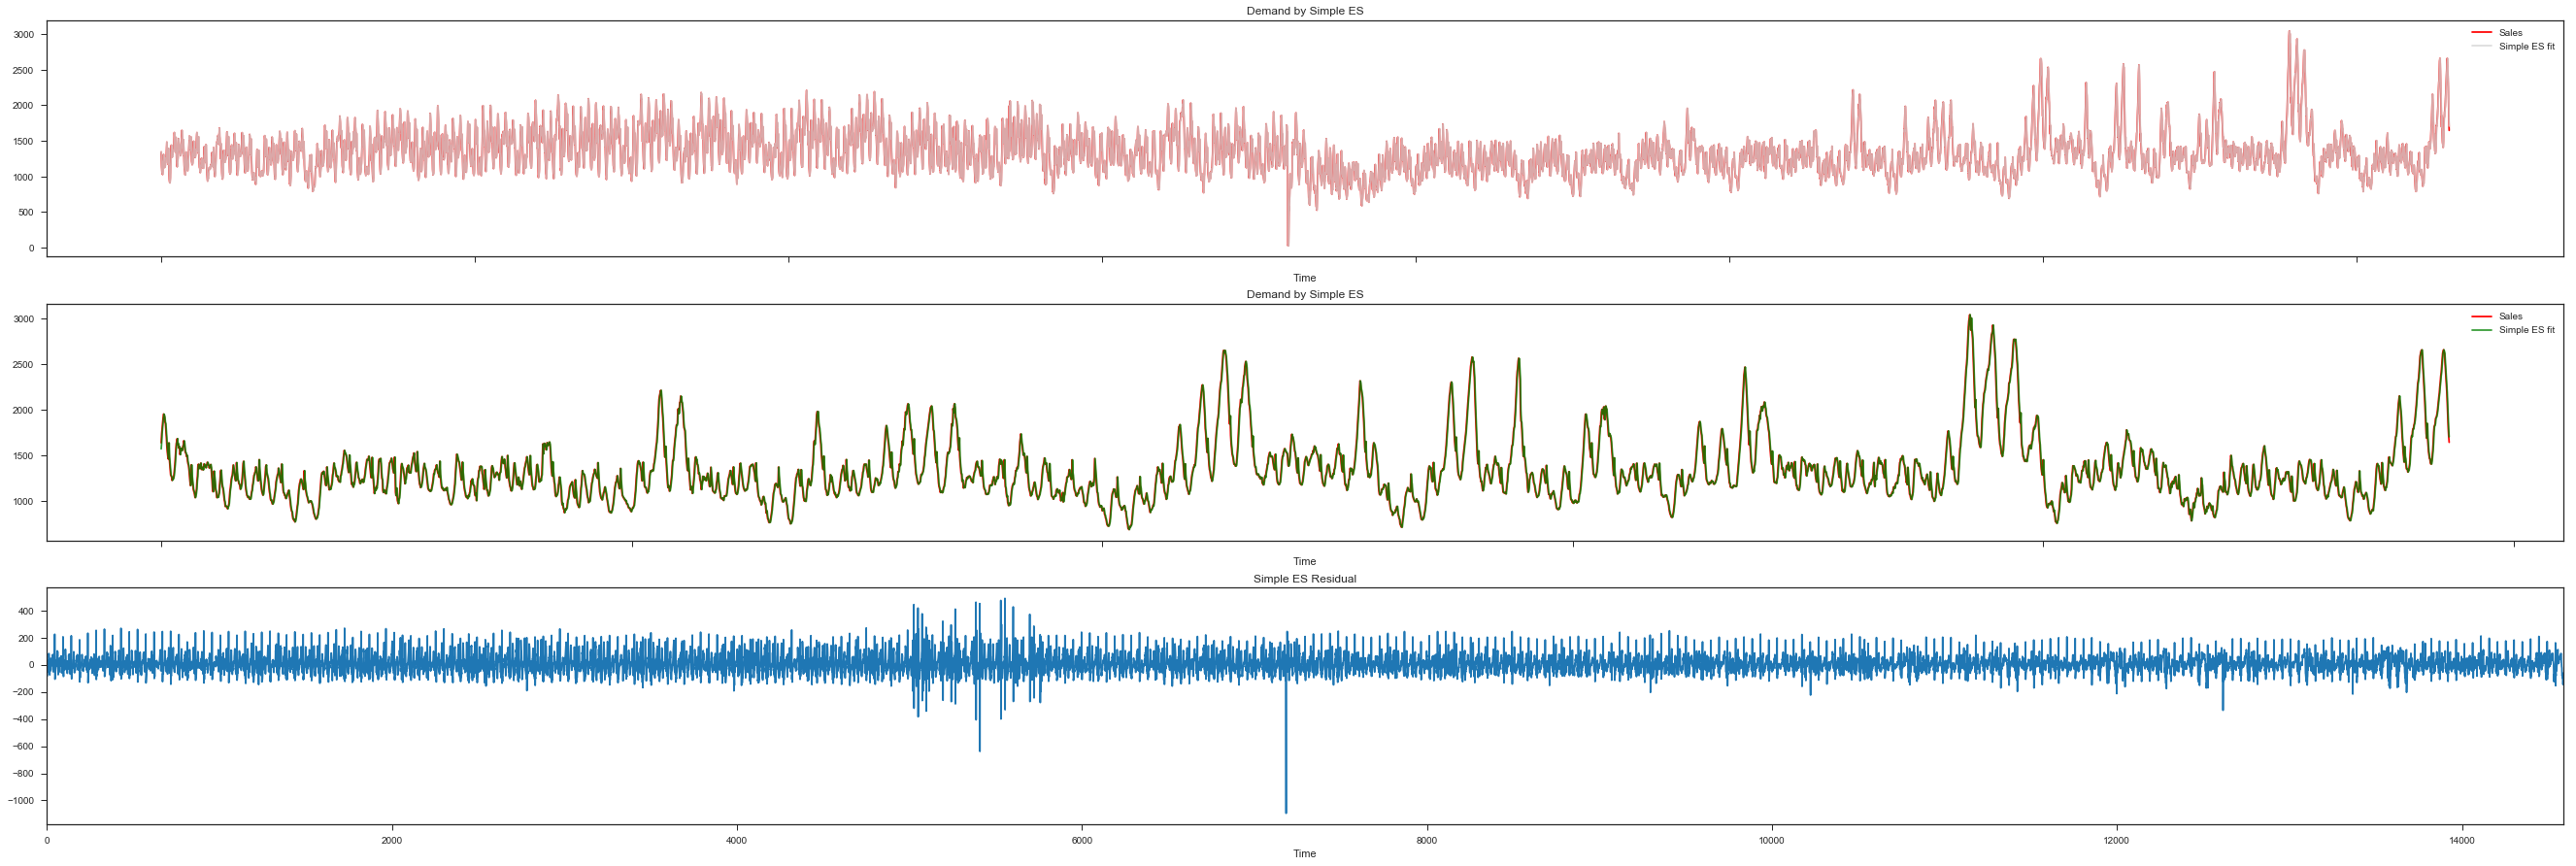

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=1)
"""
Plot original data out.
"""
plt.subplot(3,1,1)
train_data_origin["demand"].plot(color='red', label='Sales')
SES_fitted.plot(color='lightgrey', label='Simple ES fit', alpha=0.8)
plt.xlabel("Time")
plt.legend(loc='best')
plt.title("Demand by Simple ES")

plt.subplot(3,1,2)
train_data_origin["demand"][int(len(train_data_origin["demand"])/1.5):].plot(color='red', label='Sales')
SES_fitted[int(len(train_data_origin["demand"])/1.5):].plot(color='green', label='Simple ES fit', alpha=0.8)
plt.xlabel("Time")
plt.legend(loc='best')
plt.title("Demand by Simple ES")

"""
Plot residuals.
"""
plt.subplot(3,1,3)
sns.tsplot(ses_resid)
plt.title("Simple ES Residual")
plt.xlabel("Time")
# Fix up the spacing.
plt.subplots_adjust(left=5, bottom=None, right=11, top=3, wspace=None, hspace=None)
plt.show()

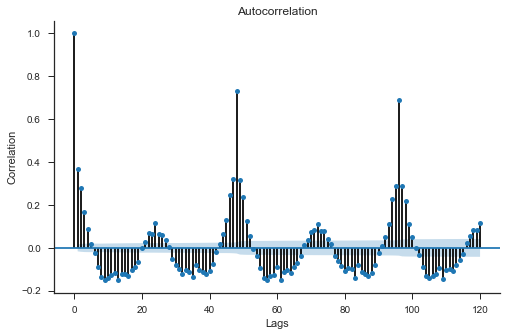

In [53]:
fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlabel('Lags')
ax.set_ylabel('Correlation')
ax.set_title('Correlogram for residuals')
sm.graphics.tsa.plot_acf(ses_resid, lags=40*3, ax=ax)
sns.despine()
plt.show()

###### Simple ES
bad performannce, too

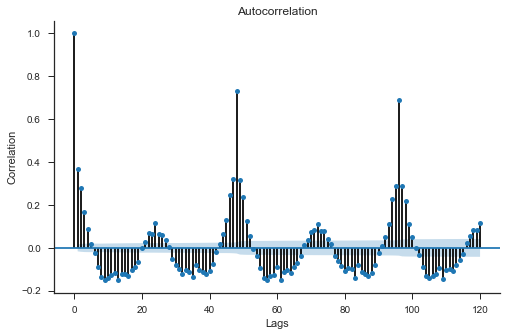

In [14]:
import forecast
#Removed weekends and holidays
ses_p1 = forecast.ses(train_data_origin['demand'])
ses_p1.fit()
ses_fitted_p1 = pd.Series(ses_p1.smooth(), index=train_data_origin.index)
ses_resid_p1 = train_data_origin['demand']-ses_fitted_p1

fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlabel('Lags')
ax.set_ylabel('Correlation')
ax.set_title('Correlogram for residuals')
sm.graphics.tsa.plot_acf(ses_resid_p1, lags=40*3, ax=ax)
sns.despine()
plt.show()

##### SE Model diagnostics

**residual are autocorrelated! So model is bad!**

### Model 3: Seasonal ARIMA - Univariate

Seasonal factor 
- withinDay 

#### Single Seasonal ARIMA 
- with in-day seasonality 
- as detrend before, so  trend='n'


In [23]:
def draw_acf_pacf(data, lags): 
    """
    Run ACF/PACF plot on the final stationary-data and check
    """
    print("🙂 Lags below is {}".format(lags))
    fig, ax = plt.subplots(1,2, figsize=(12,3)) 
    sm.graphics.tsa.plot_acf(data, lags=lags, ax=ax[0]) 
    sm.graphics.tsa.plot_pacf(data, lags=lags, ax=ax[1]) 
    sns.despine()
    fig.tight_layout()
    plt.show()

🙂 Lags below is 150


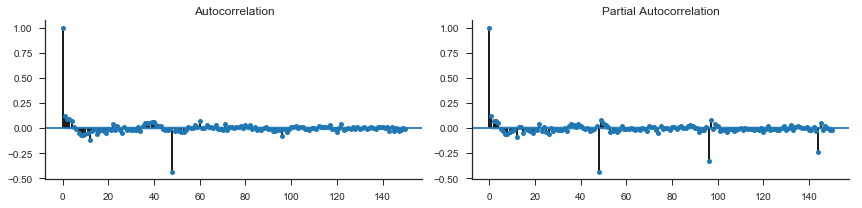

🙂 Lags below is 50


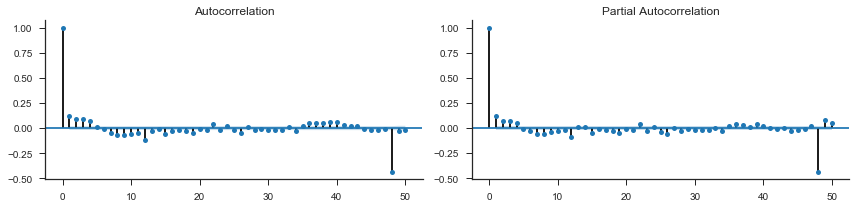

In [24]:
# demand now is after first and seasonality stationary! 
draw_acf_pacf(train_data_stationary['demand'], 50*3)
draw_acf_pacf(train_data_stationary['demand'], 50)


**BanchMark** 
- model selection based on ACF and PACF plot above

$$ ARIMA(4,1,0),(0,1,1)_{48}$$ 
- As partional autocorrelation cut off after lag 4, 
- Sample autocorrelation decrease exponentionally. 

- Sample autocorrelation cut off after lag 1*48, 
- Sample partional autocorrelation decrease exponentionally for lag 1*48, 2*48 etc. 

In [68]:
#train_data['demand'] = train_data['demand'].values.astype(float)
# within seasonality
#as detrend before,trend='n'
mod = sm.tsa.statespace.SARIMAX(train_data_stationary['demand'], trend='n', 
                                order=(4,0,0), \
                                seasonal_order=(0,0,1,48)\
                                ,simple_differencing=True) 
sarima_benchmark = mod.fit()
print(sarima_benchmark.aic)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


120645.1616757744


- trend = 'n' : AIC: 118658
- trend = 'c' : AIC: 118660
- trend = 't' : AIC: 120643
- trend = 'ct' : AIC: 120645

##### simple_differencing=True. improve model
Notice that here we used an additional argument **simple_differencing=True.** This controls how the order of integration is handled in ARIMA models. If simple_differencing=True, then the time series provided as endog is literatlly differenced and an ARMA model is fit to the resulting new time series. This implies that a number of initial periods are lost to the differencing process, however it may be necessary either to compare results to other packages (e.g. Stata's arima always uses simple differencing) or if the seasonal periodicity is large.

The default is simple_differencing=False, in which case the integration component is implemented as part of the state space formulation, and all of the original data can be used in estimation.

best_aic_SARIMA=aic_selection(sarima_benchmark) 

##### SARIMA diagnostics
When fitting seasonal ARIMA models, it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. First, we get a line plot of the residual errors, suggesting that there may still be some trend information not captured by the model.

🙂 Lags below is 150


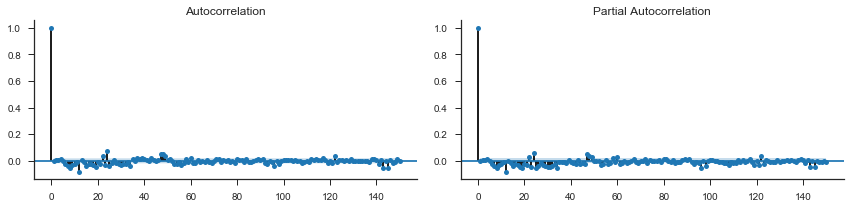

🙂 Lags below is 10


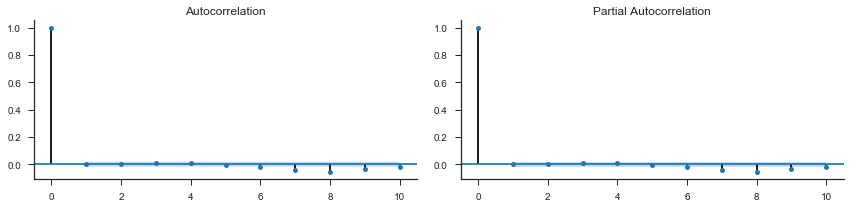

In [66]:
draw_acf_pacf(sarima_benchmark.resid, 50*3)
draw_acf_pacf(sarima_benchmark.resid, 10)

In [26]:
print(sarima_benchmark.resid.describe())

count    11710.000000
mean        -0.030048
std         38.309022
min      -1087.627019
25%        -16.599571
50%          0.465768
75%         16.877812
max        386.611148
dtype: float64


The figure displays the distribution of the residual errors. It shows a little bias in the prediction. Next, we get a density plot of the residual error values, suggesting the errors are Gaussian, and seems centered on zero.

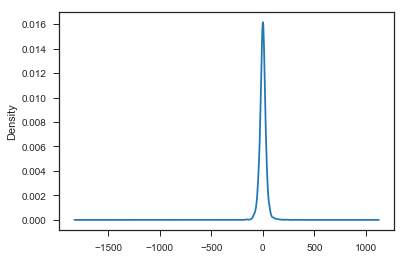

In [27]:
sarima_benchmark.resid.plot(kind='kde')

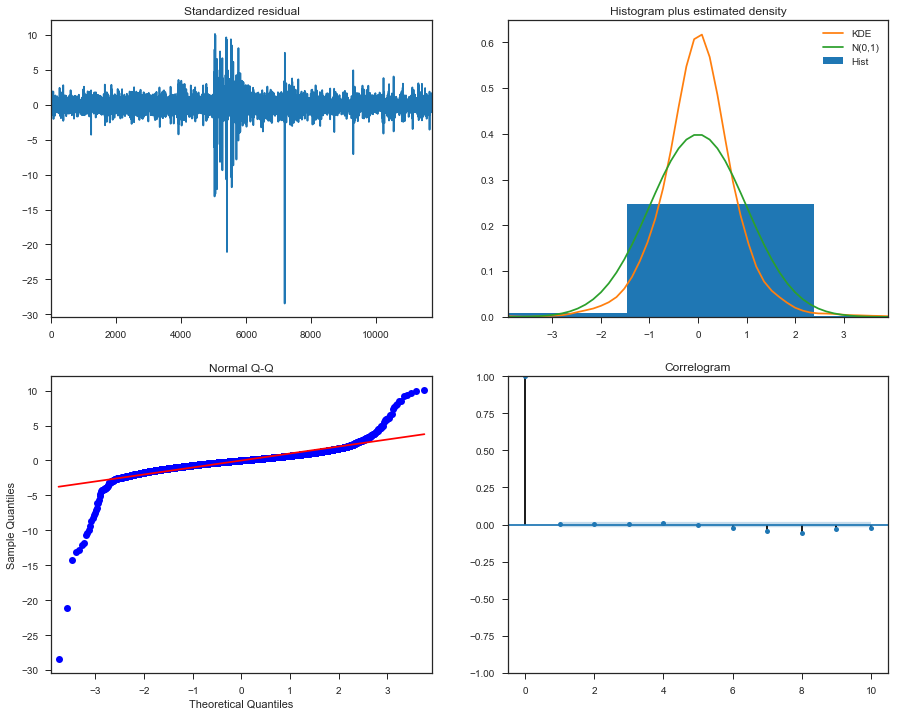

In [28]:
sarima_benchmark.plot_diagnostics(figsize=(15, 12))
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

The model diagnostic suggests that the model residual is normally distributed based on the following:

- In the top right plot, the red KDE line follows closely with the N(0,1) line. Where, N(0,1) is the standard notation for a normal distribution with mean 0 and standard deviation of 1. This is really bad indication that the residuals are not normally distributed. 

- The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) are heavy skewed.

- The residuals over time (top left plot) don't display any obvious seasonality and does not appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, perform bad. 

**Those observations lead us to conclude that our model cannot produces a satisfactory fit, so that we shall try other models.**

### Model 3: Seasonal ARIMA - with eXogenous regressors model 
Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model 

Seasonal factor 
- withinDay 
- withinnWeek

**Almost as same as uni-variate**

In [48]:
mod = sm.tsa.statespace.SARIMAX(train_data_stationary['demand'], \
            exog=train_data_stationary[['air_temp','price']],
                                trend='n',order=(4,0,0),
                                seasonal_order=(0,0,1,48),
                                simple_differencing=True) 
sarima_exog = mod.fit()
print(sarima_exog.aic)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


118658.79524190939


🙂 Lags below is 150


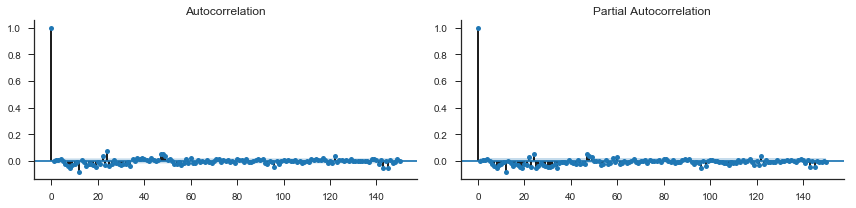

🙂 Lags below is 10


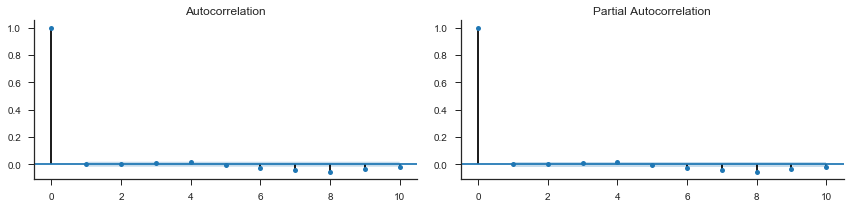

In [49]:
draw_acf_pacf(sarima_exog.resid, 50*3)
draw_acf_pacf(sarima_exog.resid, 10)